In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#file locations
diabetic_data_csv = 'Data\diabetic_data\diabetic_data.csv'
icd_codes_csv = 'Data\diabetic_data\icd_codes.csv'

In [3]:
def calculate_drop_thresh(total_values, min_percent):
    min_missing = ((1-min_percent) * total_values) + 1
    return int(min_missing)

In [4]:
def find_range_mid(given_range):
    range_lst = re.findall('\d+', given_range)
    low, high = map(int, range_lst)
    mid = (low+high)//2
    return int(mid)

In [5]:
def getIdenticalColumns(data, percent):
    min_identical_values = int(percent * data.shape[0])
    identical_columns = set()
    for column in data:
        col_counts = data[column].value_counts().values
        col_max_count = col_counts[0]
        if col_max_count >= min_identical_values:
            #print(column)
            identical_columns.add(column)
    return list(identical_columns)

In [6]:
def readmitted_boxplot(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        fig = plt.figure(figsize=(6, 6))
        fig.clf()
        ax = fig.gca()
        df.boxplot(column=[col], ax=ax, by=['readmitted'])
        plt.show()
    return 'Done'

In [7]:
def readmitted_cond_hists(df, plot_cols, grid_col):
    for col in plot_cols:
        g = sns.FacetGrid(df, col=grid_col, margin_titles=True)
        g.map(plt.hist, col)
        plt.show()

In [8]:
def getIcdCategory(icd_code):
    try:
        icd_code = float(icd_code)
    except ValueError:
        return 'Others'
    if 140 <= icd_code <= 239:
        return 'Neoplasms'
    elif 240 <= icd_code <= 279:
        return 'Endocrine'
    elif 290 <= icd_code <= 319:
        return 'Mental'
    elif 390 <= icd_code <= 459:
        return 'Circulatory'
    elif 460 <= icd_code <= 519:
        return 'Respiratory'
    elif 520 <= icd_code <= 579:
        return 'Digestive'
    elif 580 <= icd_code <= 629:
        return 'Genitourinary'
    elif 680 <= icd_code <= 709:
        return 'Skin'
    elif 710 <= icd_code <= 739:
        return 'Musculoskeletal'
    elif 780 <= icd_code <= 799:
        return 'Ill-defined'
    elif 800 <= icd_code <= 999:
        return 'Injury'
    else:
        return 'Others'

In [9]:
def classify_for_threshold(clf, testX, testY, t):
    prob_df = pd.DataFrame(clf.predict_proba(testX)[:, 1])
    prob_df['predict'] = np.where(prob_df[0]>=t, 1, 0)
    prob_df['actual'] = testY
    return pd.crosstab(prob_df['actual'], prob_df['predict'])

In [10]:
def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 15, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_
        # Inertia: Sum of distances of samples to their closest cluster center
    fig = plt.figure(figsize=(9, 6))
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    sns.lineplot(x=list(sse.keys()), y=list(sse.values()))
    plt.grid()
    plt.savefig('elbow.png', dpi=300, bbox_inches='tight', facecolor = 'white')
    print("DONE")

### 1. Data cleaning and transformation:

In [11]:
# Load csv data to cluster
csv_file = diabetic_data_csv
raw_data = pd.read_csv(csv_file)
print("Original CSV data: ")
raw_data

Original CSV data: 


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [12]:
# Replace missing data with NaN
raw_data.replace('?', np.nan, inplace=True)

In [13]:
# Drop columns with more than 50 percent NaN values
min_thresh = calculate_drop_thresh(raw_data.shape[0], 0.5)
raw_data = raw_data.dropna(axis='columns', thresh=min_thresh)
print("Dropped columns with more than 50% NaN values: ")
raw_data.shape

Dropped columns with more than 50% NaN values: 


(101766, 49)

In [14]:
# Drop columns that are 95% Identical
columns_to_drop = getIdenticalColumns(raw_data, 0.95)
raw_data = raw_data.drop(columns=columns_to_drop)
print("Dropped columns that are 95% identical: ")
raw_data.shape

Dropped columns that are 95% identical: 


(101766, 33)

In [15]:
# Saving a copy of initially cleaned data
raw_data_initial_clean = raw_data.copy(deep= True)

In [16]:
#Transform the age to be the middle value in each given range
raw_data['age'] = raw_data_initial_clean['age'].transform(find_range_mid)
print("Transformed age to mid :")
raw_data.head(3)

Transformed age to mid :


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,5,6,25,1,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,15,1,1,7,3,NaN,...,No,No,No,No,No,No,Up,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,NaN,...,No,No,Steady,No,No,No,No,No,Yes,NO


In [17]:
#Replace missing values in diag_1, diag_2, and diag_3 with zero
raw_data['diag_1'] = raw_data['diag_1'].replace(np.nan, 0)
raw_data['diag_2'] = raw_data['diag_2'].replace(np.nan, 0)
raw_data['diag_3'] = raw_data['diag_3'].replace(np.nan, 0)
print("Replaced missing values in diag_1, diag_2, and diag_3 with zero :")
raw_data.head(3)

Replaced missing values in diag_1, diag_2, and diag_3 with zero :


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,5,6,25,1,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,15,1,1,7,3,NaN,...,No,No,No,No,No,No,Up,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,NaN,...,No,No,Steady,No,No,No,No,No,Yes,NO


In [18]:
#Drop all rows with missing values
raw_data = raw_data.dropna(axis= 0, how= 'any')
print("Dropped all rows with missing values :")
raw_data.shape

Dropped all rows with missing values :


(27140, 33)

In [19]:
#Change column values to 0 if the value is NO and else 1
raw_data.loc[raw_data['readmitted'] == 'NO', 'readmitted'] = 0
raw_data.loc[raw_data['readmitted'] != 0, 'readmitted'] = 1
raw_data['readmitted'] = raw_data['readmitted'].astype(int)
print('Data after transforming readmitted column:')
raw_data

Data after transforming readmitted column:


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
20446,72091308,20123568,Caucasian,Female,75,1,22,7,7,MC,...,No,No,No,No,Up,No,Steady,Ch,Yes,0
20737,72848634,20377854,Caucasian,Female,65,2,1,1,3,MC,...,No,No,No,No,No,No,Steady,No,Yes,0
20824,73062156,20408121,Caucasian,Female,95,1,1,7,4,MC,...,No,Steady,No,No,No,No,No,No,Yes,0
21083,73731852,20542797,Caucasian,Male,75,1,2,7,10,MC,...,Steady,No,No,No,No,No,Steady,Ch,Yes,0
23879,81355914,7239654,Caucasian,Female,75,1,3,6,12,UN,...,No,No,No,No,No,No,Steady,No,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101735,443739044,106595208,Caucasian,Male,75,2,6,7,6,MC,...,No,No,No,No,No,No,Up,Ch,Yes,0
101743,443793668,47293812,Caucasian,Male,85,1,13,7,3,MC,...,No,No,No,Up,No,Steady,Down,Ch,Yes,0
101747,443804570,33230016,Caucasian,Female,75,1,22,7,8,MC,...,No,No,No,No,No,No,Steady,No,Yes,1
101749,443816024,106392411,Caucasian,Female,75,3,6,1,3,MC,...,Steady,No,Steady,No,No,No,Steady,Ch,Yes,0


In [20]:
numerical_features = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                      'num_medications', 'number_outpatient', 'number_emergency',
                      'number_inpatient', 'number_diagnoses']

In [21]:
#Remove outliers
#Removing values that are within 3 standard deviations away from the mean
for col in numerical_features:
    #z-score = (score - mean)/standard deviation
    raw_data = raw_data[(np.abs(stats.zscore(raw_data[col])) < 3)]
print("Removed outliers :")
raw_data

Removed outliers :


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
20446,72091308,20123568,Caucasian,Female,75,1,22,7,7,MC,...,No,No,No,No,Up,No,Steady,Ch,Yes,0
20737,72848634,20377854,Caucasian,Female,65,2,1,1,3,MC,...,No,No,No,No,No,No,Steady,No,Yes,0
20824,73062156,20408121,Caucasian,Female,95,1,1,7,4,MC,...,No,Steady,No,No,No,No,No,No,Yes,0
21083,73731852,20542797,Caucasian,Male,75,1,2,7,10,MC,...,Steady,No,No,No,No,No,Steady,Ch,Yes,0
23879,81355914,7239654,Caucasian,Female,75,1,3,6,12,UN,...,No,No,No,No,No,No,Steady,No,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101735,443739044,106595208,Caucasian,Male,75,2,6,7,6,MC,...,No,No,No,No,No,No,Up,Ch,Yes,0
101743,443793668,47293812,Caucasian,Male,85,1,13,7,3,MC,...,No,No,No,Up,No,Steady,Down,Ch,Yes,0
101747,443804570,33230016,Caucasian,Female,75,1,22,7,8,MC,...,No,No,No,No,No,No,Steady,No,Yes,1
101749,443816024,106392411,Caucasian,Female,75,3,6,1,3,MC,...,Steady,No,Steady,No,No,No,Steady,Ch,Yes,0


In [22]:
#Remove duplicates in the column patient_nbr
raw_data = raw_data.drop_duplicates(subset='patient_nbr', keep='first')

In [23]:
#shape of the resulting dataframe after Data cleaning and transformation
print('raw_data shape:')
raw_data.shape

#Part 1-> Step 1:- Data cleaning and transformation: Completed

raw_data shape:


(18807, 33)

### 2. Data exploration:

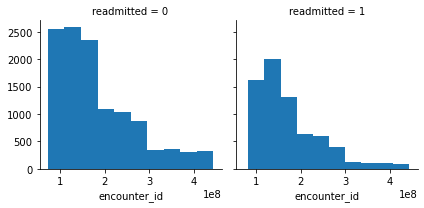

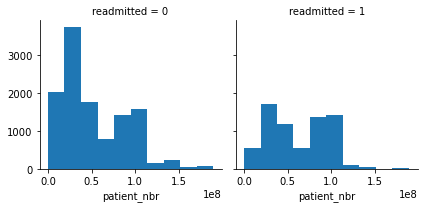

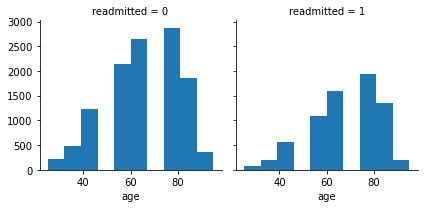

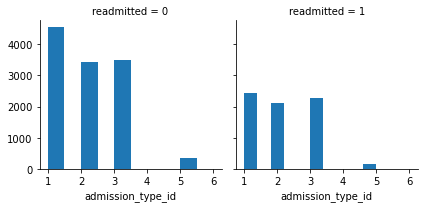

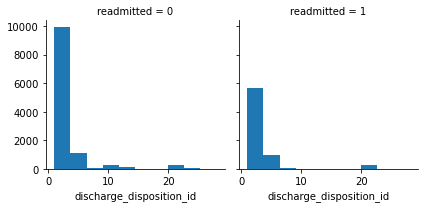

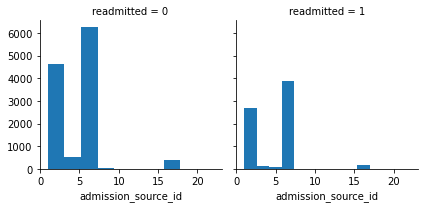

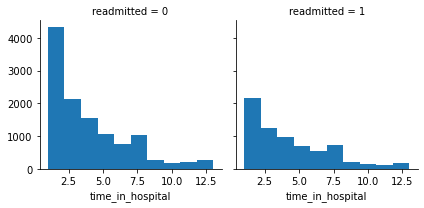

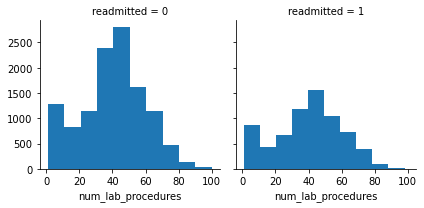

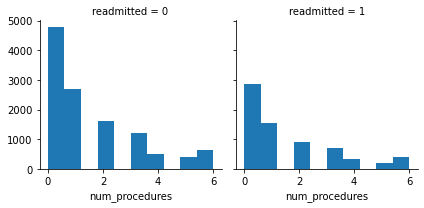

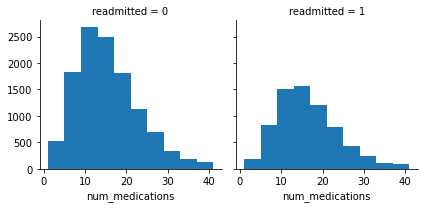

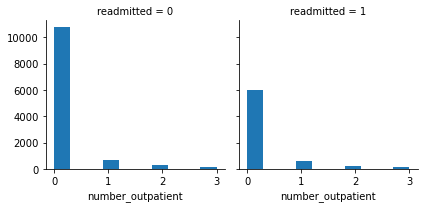

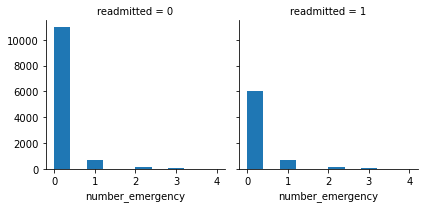

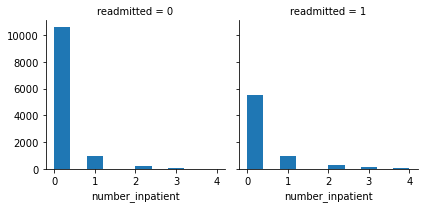

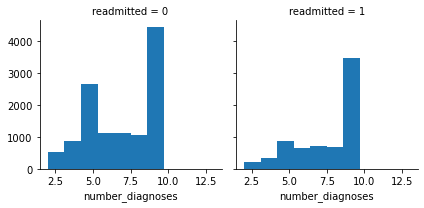

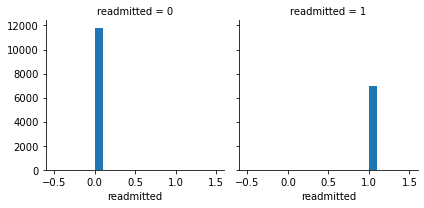

In [24]:
readmitted_cond_hists(raw_data, raw_data.select_dtypes(include=[np.number]).columns, "readmitted")

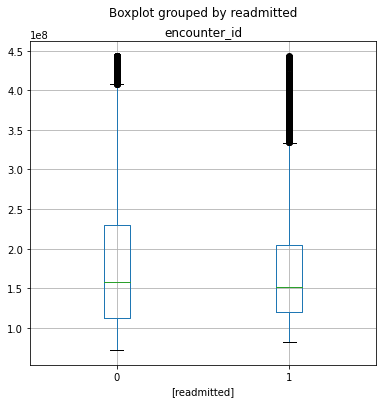

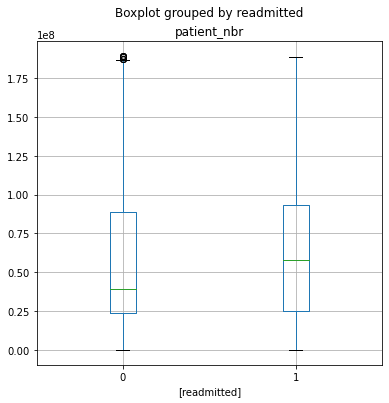

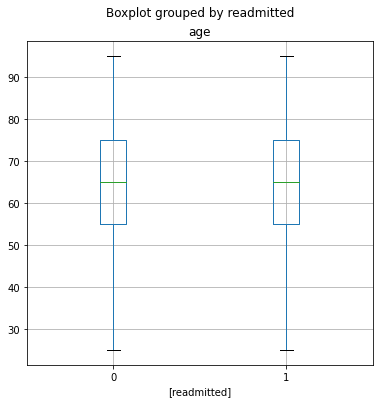

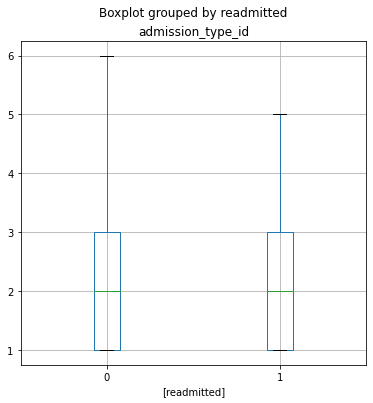

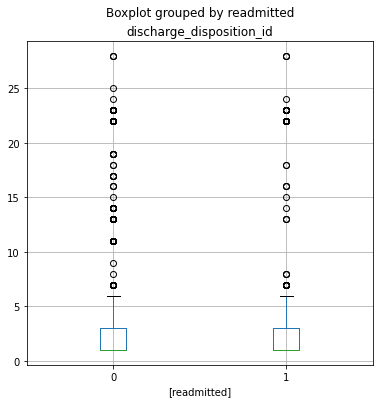

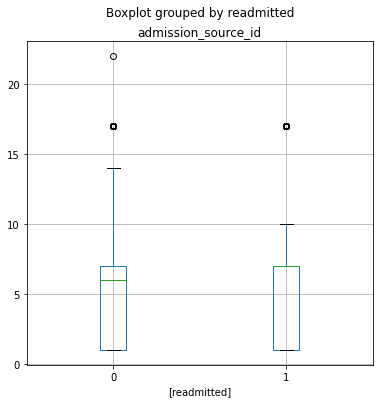

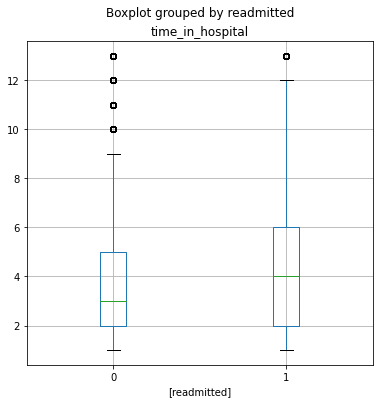

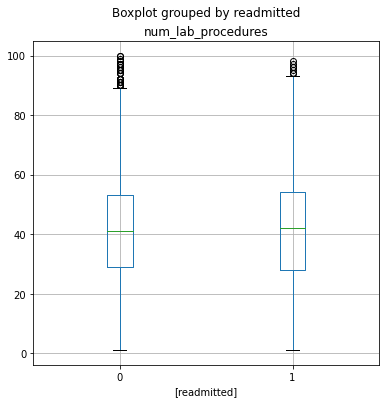

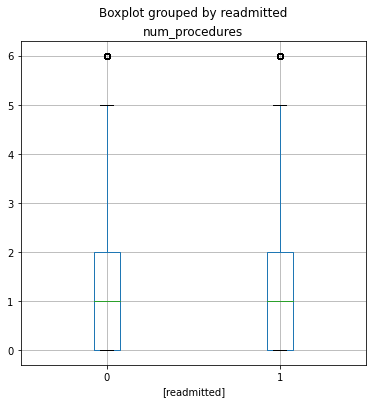

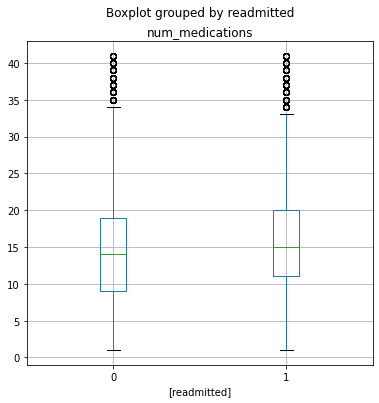

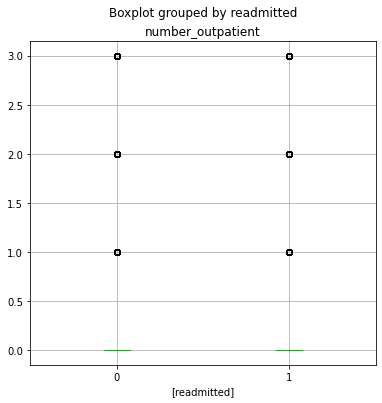

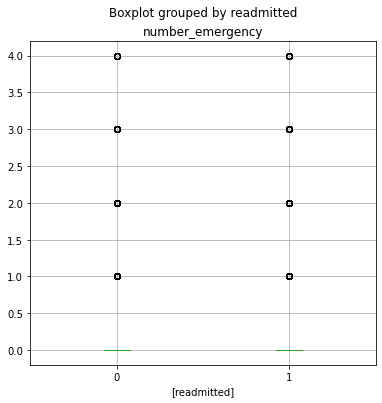

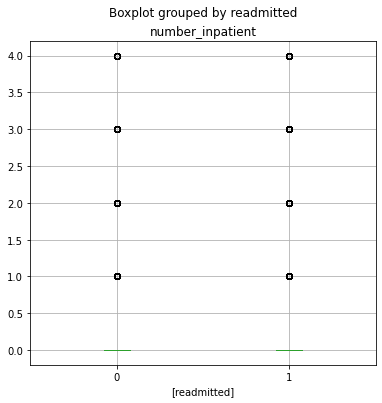

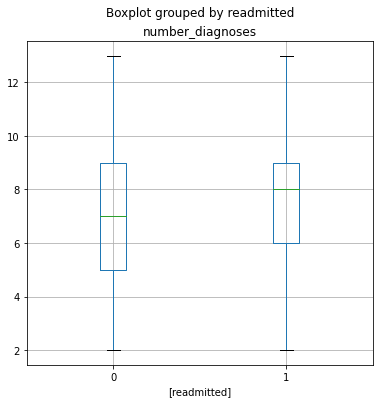

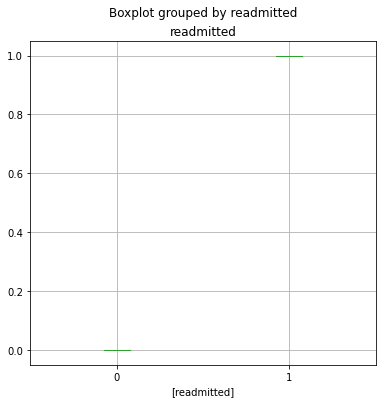

'Done'

In [25]:
readmitted_boxplot(raw_data)

In [26]:
raw_data_copy_before_category = raw_data.copy(deep= True)

In [27]:
#Icd categories to reduce icd values
icd_categories = {'category': ['Neoplasms', 'Endocrine', 'Mental', 'Circulatory', 'Respiratory', 'Digestive',
                               'Genitourinary', 'Skin', 'Musculoskeletal', 'Ill-defined', 'Injury', 'Others'
                               ],
               'description': ['Neoplasms', 'Endocrine, nutritional and metabolic diseases, and immunity disorders',
                               'mental disorders', 'diseases of the circulatory system', 'diseases of the respiratory system',
                               'diseases of the digestive system', 'diseases of the genitourinary system',
                               'diseases of the skin and subcutaneous tissue',
                               'diseases of the musculoskeletal system and connective tissue',
                               'symptoms, signs, and ill-defined conditions',
                               'injury and poisoning', 'Others'
                               ]
               }

icd_categories_df = pd.DataFrame(icd_categories)

In [28]:
# Load icd codes csv data to cluster to join
icd_codes = icd_codes_csv
icd_codes_df = pd.read_csv(icd_codes)

icd_codes_df.insert(1, 'Category', icd_codes_df['ICD_Code'])
for index, row in icd_codes_df.iterrows():
    icd_codes_df.loc[index, 'Category'] = getIcdCategory(row['Category'])

In [29]:
raw_data = pd.merge(raw_data, icd_codes_df[['ICD_Code', 'Category']], how='left', left_on='diag_1', right_on='ICD_Code')
raw_data.rename({'Category': 'diag_1_category'}, axis=1, inplace=True)
raw_data = raw_data.drop(columns='ICD_Code')

raw_data = pd.merge(raw_data, icd_codes_df[['ICD_Code', 'Category']], how='left', left_on='diag_2', right_on='ICD_Code')
raw_data.rename({'Category': 'diag_2_category'}, axis=1, inplace=True)
raw_data = raw_data.drop(columns='ICD_Code')

raw_data = pd.merge(raw_data, icd_codes_df[['ICD_Code', 'Category']], how='left', left_on='diag_3', right_on='ICD_Code')
raw_data.rename({'Category': 'diag_3_category'}, axis=1, inplace=True)
raw_data = raw_data.drop(columns='ICD_Code')

In [30]:
merged_data = raw_data.copy(deep= True)

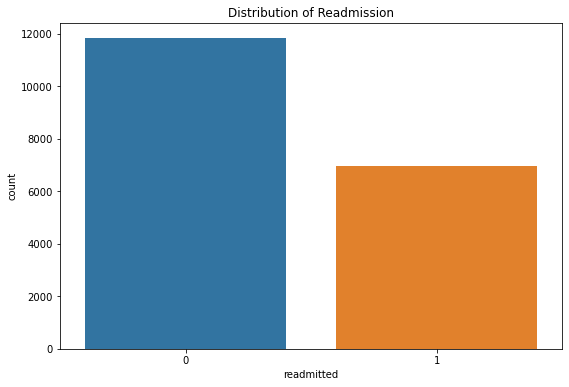

In [31]:
fig = plt.figure(figsize=(9, 6))
sns.countplot(x='readmitted', data=raw_data).set_title('Distribution of Readmission')
plt.savefig('readmission.png', dpi=300, bbox_inches='tight', facecolor = 'white')

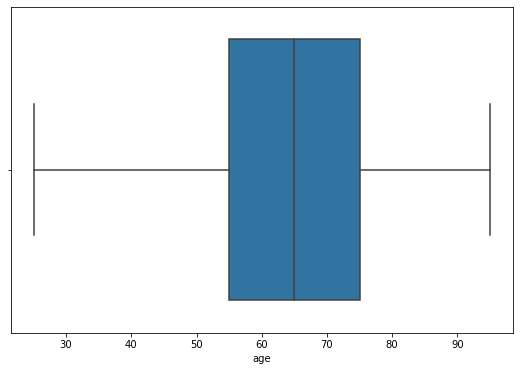

In [32]:
fig = plt.figure(figsize=(9, 6))
x = raw_data['age']
sns.boxplot(x=x)
plt.savefig('age_box_plot.png', dpi=300, bbox_inches='tight', facecolor = 'white')

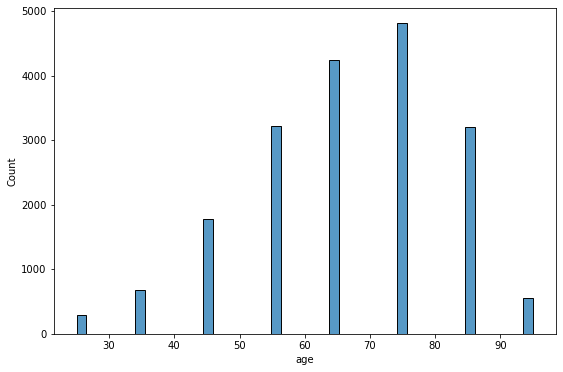

In [33]:
fig = plt.figure(figsize=(9, 6))
x = raw_data['age']
sns.histplot(x=x)
plt.savefig('age_hist_plot.png', dpi=300, bbox_inches='tight', facecolor = 'white')

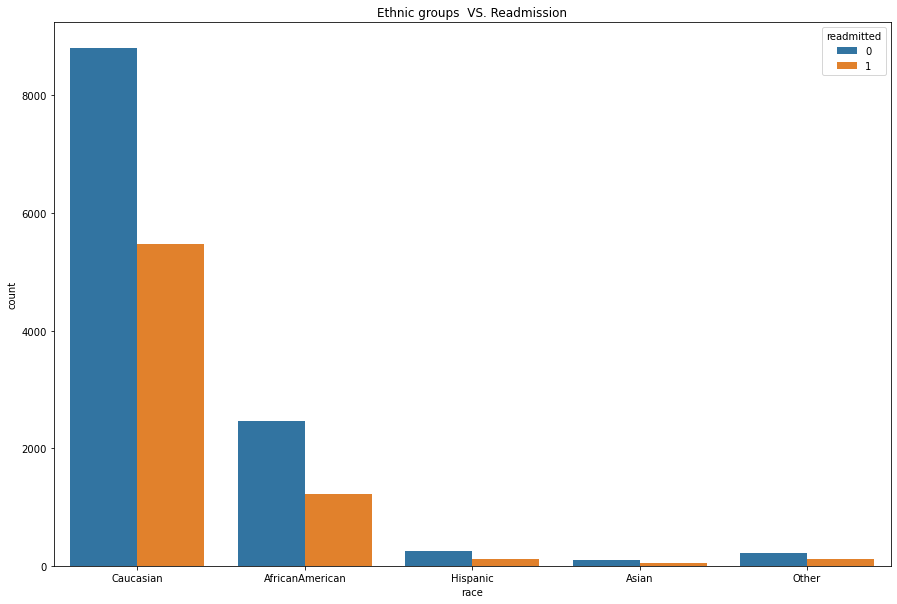

In [34]:
fig = plt.figure(figsize=(15, 10))
x = raw_data['race']
hue = raw_data['readmitted']
sns.countplot(x=x, hue=hue).set_title('Ethnic groups  VS. Readmission')
plt.savefig('race.png', dpi=300, bbox_inches='tight', facecolor = 'white')

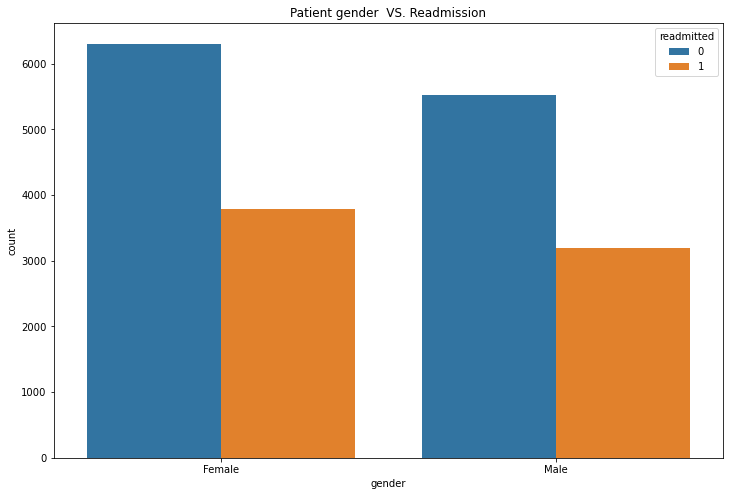

In [35]:
fig = plt.figure(figsize=(12, 8))
x = raw_data['gender']
hue = raw_data['readmitted']
sns.countplot(x=x, hue=hue).set_title('Patient gender  VS. Readmission')
plt.savefig('gender.png', dpi=300, bbox_inches='tight', facecolor = 'white')

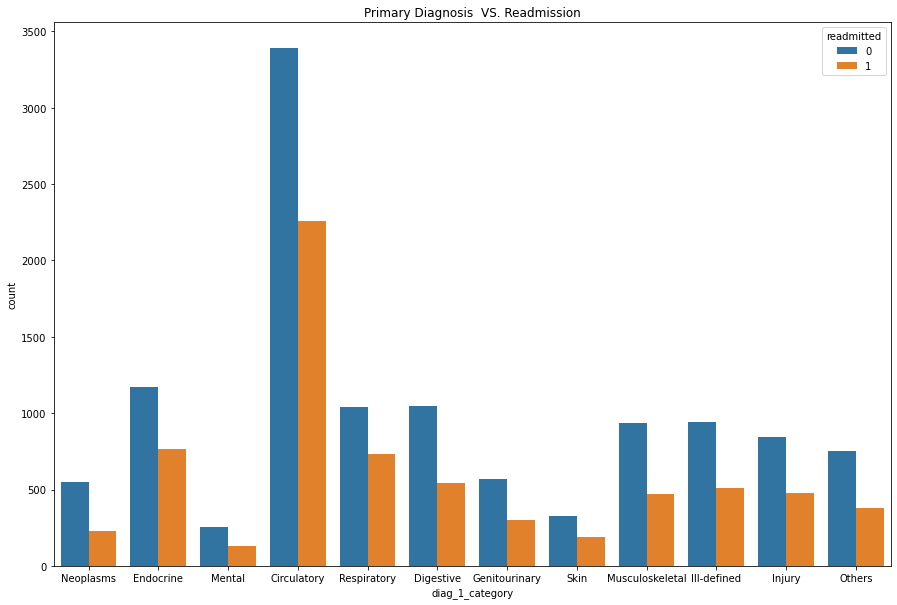

In [36]:
fig = plt.figure(figsize=(15, 10))
x = raw_data['diag_1_category']
hue = raw_data['readmitted']
order = icd_categories_df['category']
sns.countplot(x=x, hue=hue, order=order).set_title('Primary Diagnosis  VS. Readmission')
plt.savefig('diag1.png', dpi=300, bbox_inches='tight', facecolor = 'white')

### 3. Model building

In [37]:
sub_df_col = ['num_medications', 'number_outpatient', 'number_emergency',
              'time_in_hospital', 'number_inpatient', 'encounter_id',
              'age', 'num_lab_procedures', 'number_diagnoses',
              'num_procedures', 'readmitted']

In [38]:
sub_df = raw_data[sub_df_col]

In [39]:
scaler = MaxAbsScaler()
scaler.fit(sub_df)
scaled = scaler.transform(sub_df)
scaled_df = pd.DataFrame(scaled, columns=sub_df.columns)
scaled_df['readmitted'] = sub_df['readmitted']
sub_df = scaled_df

In [40]:
X = sub_df.loc[:, sub_df.columns != 'readmitted']
y = sub_df['readmitted']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
logit = LogisticRegression(penalty='l1', solver='liblinear')
logit.fit(X_train, y_train)

logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(logit_pred, name='Predict'), margins=True)

print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))
print("Mean hits: {}".format(np.mean(logit_pred == y_test)))

Accuracy is 0.64
Precision is 0.53
Recall is 0.18
Mean hits: 0.6353003721424774


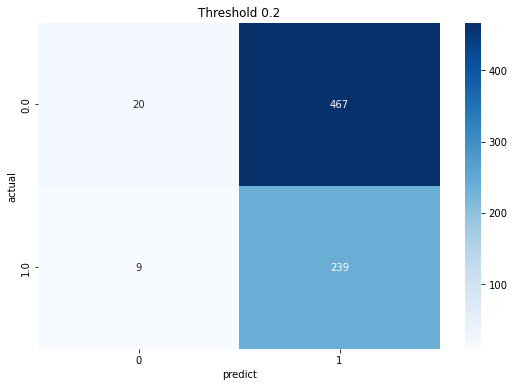

In [42]:
fig = plt.figure(figsize=(9, 6))
cross_tab = classify_for_threshold(logit, X_test, y_test, 0.2)
sns.heatmap(cross_tab, annot= True, fmt='g', cmap="Blues").set_title('Threshold 0.2')
plt.savefig('cm_0_2.png', dpi=300, bbox_inches='tight', facecolor = 'white')

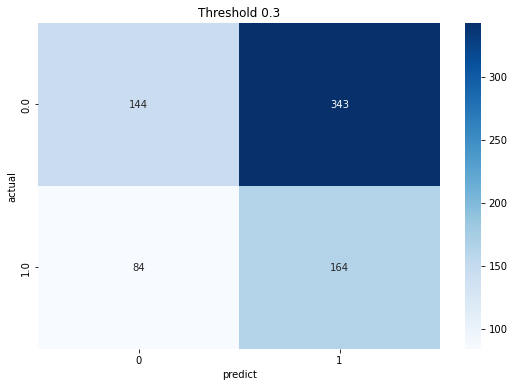

In [43]:
fig = plt.figure(figsize=(9, 6))
cross_tab = classify_for_threshold(logit, X_test, y_test, 0.3)
sns.heatmap(cross_tab, annot= True, fmt='g', cmap="Blues").set_title('Threshold 0.3')
plt.savefig('cm_0_3.png', dpi=300, bbox_inches='tight', facecolor = 'white')

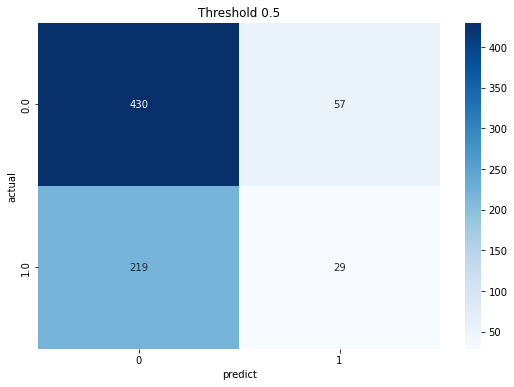

In [44]:
fig = plt.figure(figsize=(9, 6))
cross_tab = classify_for_threshold(logit, X_test, y_test, 0.5)
sns.heatmap(cross_tab, annot= True, fmt='g', cmap="Blues").set_title('Threshold 0.5')
plt.savefig('cm_0_5.png', dpi=300, bbox_inches='tight', facecolor = 'white')

In [45]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=8)
scores
print("Mean scores: {}".format(scores.mean()))

Mean scores: 0.6432177570431776


In [46]:
sub_df.groupby('readmitted').mean()

,num_medications,number_outpatient,number_emergency,time_in_hospital,number_inpatient,encounter_id,age,num_lab_procedures,number_diagnoses,num_procedures
readmitted,,,,,,,,,,
0,0.365004,0.045989,0.023480,0.303680,0.034787,0.411255,0.691027,0.400590,0.529188,0.245484
1,0.387885,0.072131,0.044569,0.329651,0.079858,0.387420,0.715874,0.400251,0.575369,0.246585


### Clustering

In [47]:
#########
## call KMeans algo with 6 clusters
model = KMeans(n_clusters=6)
model.fit(sub_df)
## J score
print('J-score = ', model.inertia_)
print(model.labels_)

J-score =  4705.215500461639
[0 3 2 ... 0 5 0]


In [48]:
labels = model.labels_
md = pd.Series(labels)
sub_df['clust'] = md
sub_df.head(5)

,num_medications,number_outpatient,number_emergency,time_in_hospital,number_inpatient,encounter_id,age,num_lab_procedures,number_diagnoses,num_procedures,readmitted,clust
0,0.365854,0.0,0.0,0.538462,0.0,0.162435,0.789474,0.58,0.692308,0.333333,0,0
1,0.268293,0.0,0.0,0.230769,0.0,0.164142,0.684211,0.59,0.461538,0.500000,0,3
2,0.219512,0.0,0.0,0.307692,0.0,0.164623,1.000000,0.56,0.461538,0.166667,0,2
3,0.439024,0.0,0.0,0.769231,0.0,0.166132,0.789474,0.68,0.461538,0.166667,0,0
4,0.463415,0.0,0.0,0.923077,0.0,0.183310,0.789474,0.77,0.384615,0.833333,0,3


In [49]:
## cluster centers
centroids = model.cluster_centers_
print ('centroids', centroids)

centroids [[4.88999380e-01 4.41791654e-02 2.75482094e-02 5.13079513e-01
  5.54790328e-02 4.56028599e-01 7.44881027e-01 5.27952250e-01
  6.13265522e-01 1.70747883e-01 1.77635684e-15]
 [2.95272915e-01 6.25794466e-02 4.33411558e-02 2.22284902e-01
  5.41947785e-02 3.57624573e-01 7.08140989e-01 3.25799355e-01
  5.35708645e-01 8.99579544e-02 1.00000000e+00]
 [2.80579889e-01 4.63996498e-02 2.46224557e-02 2.03684530e-01
  2.72898884e-02 3.75600876e-01 6.68659502e-01 3.43286277e-01
  4.83244103e-01 9.58087109e-02 1.05471187e-15]
 [4.09222870e-01 4.73684211e-02 1.52834008e-02 2.73341638e-01
  2.59109312e-02 4.39971792e-01 6.74962710e-01 3.73465587e-01
  5.31298661e-01 7.13495277e-01 1.49880108e-15]
 [5.02636628e-01 8.85539331e-02 5.38153556e-02 5.08315519e-01
  1.42840320e-01 4.17147623e-01 7.33991125e-01 5.34950542e-01
  6.33283815e-01 1.73889151e-01 1.00000000e+00]
 [4.37742469e-01 7.05394191e-02 3.38865837e-02 3.20459623e-01
  4.78907331e-02 4.14016668e-01 7.07505278e-01 3.78008299e-01
  5.83

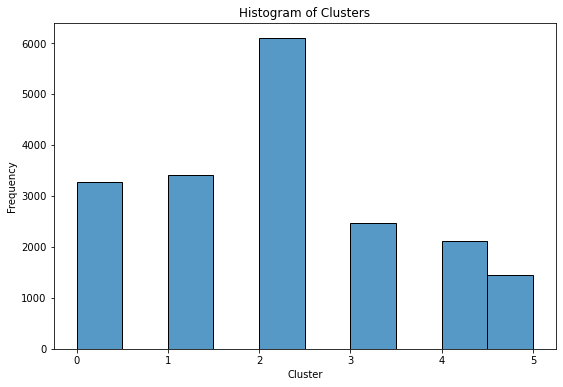

In [50]:
fig = plt.figure(figsize=(9, 6))
sns.histplot(data=sub_df, x="clust", binwidth=0.5)
plt.title('Histogram of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.savefig('clust_hist.png', dpi=300, bbox_inches='tight', facecolor = 'white')

In [51]:
## means of the clusters
#print ('clustered data', df_norm)
sub_df.groupby('clust').mean()

,num_medications,number_outpatient,number_emergency,time_in_hospital,number_inpatient,encounter_id,age,num_lab_procedures,number_diagnoses,num_procedures,readmitted
clust,,,,,,,,,,,
0,0.489193,0.044179,0.027548,0.513339,0.055479,0.456036,0.744881,0.528041,0.613171,0.171309,0.0
1,0.295202,0.062598,0.043354,0.222237,0.054211,0.357617,0.708148,0.325798,0.535663,0.089984,1.0
2,0.280668,0.046384,0.024614,0.203782,0.027281,0.375628,0.668768,0.343454,0.483452,0.095668,0.0
3,0.408853,0.047407,0.015296,0.272815,0.025932,0.439948,0.674699,0.372958,0.530950,0.713601,0.0
4,0.502653,0.088512,0.053790,0.508257,0.142773,0.417131,0.733968,0.534854,0.633312,0.173807,1.0
5,0.437742,0.070539,0.033887,0.320460,0.047891,0.414017,0.707505,0.378008,0.583839,0.722568,1.0


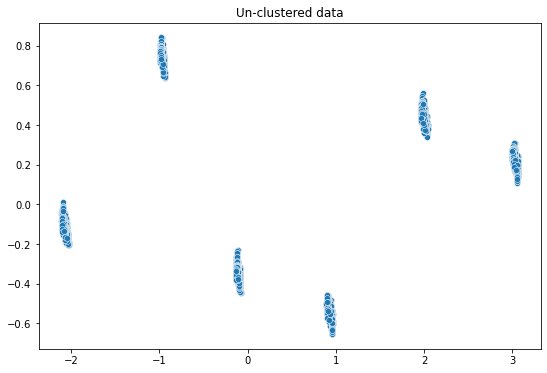

In [52]:
# 2D plot of the clusters

pca_data = PCA(n_components=2).fit(sub_df)
pca_2d = pca_data.transform(sub_df)

fig = plt.figure(figsize=(9, 6))
sns.scatterplot(x=pca_2d[:,0], y=pca_2d[:,1])
plt.title('Un-clustered data')
plt.savefig('un_clust_data.png', dpi=300, bbox_inches='tight', facecolor = 'white')

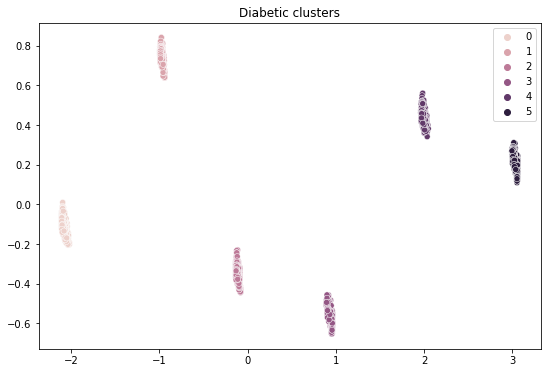

In [53]:
# 2D plot of the clusters
fig = plt.figure(figsize=(9, 6))
sns.scatterplot(x=pca_2d[:,0], y=pca_2d[:,1], hue=labels)
plt.title('Diabetic clusters')
plt.savefig('diabetic_clust.png', dpi=300, bbox_inches='tight', facecolor = 'white')


Plotting elbow method...
2 22195.871269147196
4 8368.35528156663
6 4705.211075153068
8 4419.584662314385
10 4202.97710139314
12 4033.252855265533
14 3830.786030314075
DONE


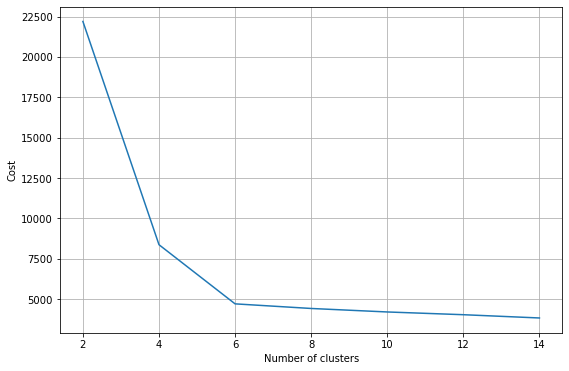

In [54]:
elbow(sub_df)